100%|██████████| 400/400 [01:33<00:00,  4.28it/s]


optimal policy: 
 [[0 3 0 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]
average reward after 100th iteration: 0.7826666666666667


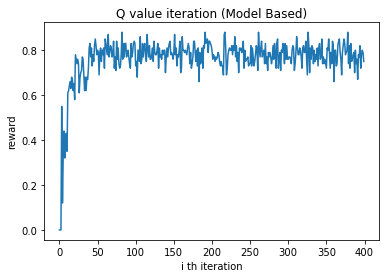

In [4]:
################################################################
# Frozen Lake v1 : Q value iteration example 
################################################################


import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm

# Parameters 
GAMMA = 0.9
ENV_NAME = "FrozenLake-v1"

class ModelBased(gym.Wrapper):
    def __init__(self, env):
        super(ModelBased, self).__init__(env)
        
        STATE_DIM = self.env.observation_space.n
        ACTION_DIM = self.env.action_space.n
        
        self.q_table = np.zeros([STATE_DIM, ACTION_DIM])
        self.transtions_model = np.zeros([STATE_DIM , ACTION_DIM, STATE_DIM])
        self.rewards_model = np.zeros([STATE_DIM , ACTION_DIM, STATE_DIM])
        
        self.num_episodes = 100
        self.GAMMA = GAMMA
    
    def select_action(self, state, training=True):
        if training:
            # choose a random action
            return self.env.action_space.sample()
        else:
            # choose the best action currently available
            _, action = np.unravel_index(np.argmax(self.q_table[state, :]), self.q_table.shape)
            return action

    def q_value_iteration(self):
        STATE_DIM = self.env.observation_space.n
        ACTION_DIM = self.env.action_space.n
        for current_state in range(STATE_DIM):
            for action in range(ACTION_DIM):
                total_transition = self.transtions_model[current_state, action, :].sum()
                if total_transition == 0.0:
                   continue
                total_bb = 0.0
                probs = self.transtions_model[current_state, action, :] / total_transition
                rewards = self.rewards_model[current_state, action, :] 
                for next_state in range(STATE_DIM):
                    reward = rewards[next_state]
                    transition_prob = probs[next_state] 
                    q_max = self.q_table[next_state, :].max()
                    bellman_backup = reward + self.GAMMA * q_max
                    total_bb += transition_prob * bellman_backup
                self.q_table[current_state, action] = total_bb
        
    
    def count_transition(self, current_state, action, next_state):
        self.transtions_model[current_state, action, next_state] += 1
    
    def count_reward(self, current_state, action, next_state, reward):
        self.rewards_model[current_state, action, next_state] = reward
        
    def run_episode(self, training=True):
        current_state, _ = self.env.reset()
        terminated = False
        episode_reward = 0.0
        
        while not terminated:
            # choose action
            action = self.select_action(current_state, training)
            
            # take action
            next_state, reward, terminated, truncated, info = self.env.step(action)
            
            # learn the model
            self.count_transition(current_state, action, next_state)
            self.count_reward(current_state, action, next_state, reward)
            
            # prepare next step
            current_state = next_state
            episode_reward += reward

        return episode_reward
        
    def run_epoch(self, training=True):
        rewards = np.zeros(self.num_episodes)
        for i in range(self.num_episodes):
            rewards[i] = self.run_episode(training)
        return rewards.mean()
    
    def get_policy(self):
        policy = np.argmax(self.q_table, axis=1)
        return policy

# traning and testing
def model_based_example():
    env = gym.make(ENV_NAME)
    env = ModelBased(env)
    
    num_epochs = 400
    average_rewards = np.zeros(num_epochs)
    for iter_n in tqdm(range(num_epochs)):
        # training
        env.run_epoch(training=True)
        env.q_value_iteration()
    
        # testing
        average_reward = env.run_epoch(training=False)
        average_rewards[iter_n] = average_reward
    
    # print the optimal policy
    policy = env.get_policy()
    print("optimal policy: \n", policy.reshape(4,4)) # almost optimal?
    
    # the optimal reward is about 0.78
    print("average reward after 100th iteration:", average_rewards[100:].mean())
    
    # plot average rewards
    fig, ax = plt.subplots()
    ax.plot(average_rewards) 
    ax.set_title('Q value iteration (Model Based)')
    ax.set_xlabel('i th iteration')
    ax.set_ylabel('reward')



if __name__ == '__main__':
    model_based_example()
